In [44]:
%matplotlib inline

Between-subject SVM classification based on beta weights (per trials) averaged within networks from different grains of MIST parcellation, for CIMAQ memory encoding task (fMRI data). 

Mean network betas reflect the engagement of a particular network for each trial. 

MIST Parcellations include: 7, 12, 20, 36, 64, 122, 197, 325, 444 networks

Trials (conditions) are classifierd according to:
- task condition (encoding or control task)
- memory performance (hit vs miss, correct vs incorrect source)
- stimulus category (?)

In [50]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import nilearn
import scipy
import nibabel as nb
import sklearn
import seaborn as sns
import itertools

from numpy import nan as NaN
from matplotlib import pyplot as plt
from nilearn import image, plotting
from nilearn import masking
from nilearn import plotting
from nilearn import datasets
from nilearn.plotting import plot_stat_map, plot_roi, plot_anat, plot_img, show
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import MinMaxScaler


Step 1: import list of participants, and generate sublists of participants who have enough trials per category for each classification

1. Encoding vs Control task conditions (all 94)

2. Stimulus category (all 94)

3. Hit versus Miss (42 participants; at least 15 trials per condition)

4. Correct Source versus Wrong Source (49 participants; at least 15 trials per condition)

5. Correct Source versus Miss (38 participants; at least 15 trials per condition)


**NOTE: ADD filter to exclude participants with too many scrubbed frames?? **


In [46]:

# Path to directory with participant lists
data_file = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Participants/Splitting/Sub_list.tsv'
sub_data = pd.read_csv(data_file, sep = '\t')

# Exclude participants who failed QC
sub_data = sub_data[sub_data['QC_status']!= 'F']

## ADD filter to exclude participants with too many scrubbed frames?? ##

# Set minimal number of trials needed per subject to include them in analysis
num = 14

# Encoding vs Control, and Stimulus Category classifications
all_subs = sub_data['participant_id']
all_diagnosis = sub_data['cognitive_status']
print(all_subs)
print(len(all_subs))

# Hit versus Miss
hm_data = sub_data[sub_data['hits'] > num]
hm_data = hm_data[hm_data['miss'] > num]
hm_subs = hm_data['participant_id']
hm_diagnosis = hm_data['cognitive_status']
print(hm_subs)
print(len(hm_subs))

# Correct Source versus Wrong Source 
cw_data = sub_data[sub_data['correct_source'] > num]
cw_data = cw_data[cw_data['wrong_source'] > num]
cw_subs = cw_data['participant_id']
cw_diagnosis = cw_data['cognitive_status']
print(cw_subs)
print(len(cw_subs))

# Correct Source versus Miss
cmiss_data = sub_data[sub_data['correct_source'] > num]
cmiss_data = cmiss_data[cmiss_data['miss'] > num]
cmiss_subs = cmiss_data['participant_id']
cmiss_diagnosis = cmiss_data['cognitive_status']
print(cmiss_subs)
print(len(cmiss_subs))


0      108391
1      120839
2      122922
3      127228
4      139593
6      147863
7      150649
8      164965
9      175295
10     178101
11     189005
12     197192
14     199801
15     219637
16     229301
17     247659
18     254402
19     255499
20     258618
21     258912
22     267168
23     270218
24     271596
27     314409
28     326073
29     336665
30     337021
31     350555
32     370092
34     385370
        ...  
70     763590
71     778749
72     783781
73     785217
74     785245
75     804743
77     845675
78     866812
79     878354
80     884343
81     886007
83     893978
85     901551
86     906145
87     914042
88     915022
89     920577
90     932933
91     936730
92     938001
93     955548
94     956049
95     956130
96     968913
97     974246
98     979001
99     983291
100    988602
101    996599
102    998166
Name: participant_id, Length: 94, dtype: int64
94
0      108391
2      122922
4      139593
8      164965
14     199801
17     247659
19     25549

Step 2: For each subject list (analysis), create a group mask from individual functional mri masks.  

The mask should only include voxels included in all participants's individual functional mask (intersection). The mask will serve to vectorize 3D beta weigths maps into feature rows. 

**Update: use 0.5 treshold, otherwise too much signal drop out**

In [47]:
# Anatomical template for display
anat = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Templates/template_anat_stereo.nii'

# Path to directory with masks
mask_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/masks'

# All participants (94 participants)
all_mask_list = []
for sub in all_subs:
    mask = os.path.join(mask_dir, 'func_sub'+str(sub)+'_mask_stereonl.nii')
    all_mask_list.append(mask)
print(len(all_mask_list))    
grp_mask_all = masking.intersect_masks(mask_imgs = all_mask_list, threshold=0.5, connected=True)    

# plotting.plot_roi(roi_img=grp_mask_all, bg_img=anat, cut_coords=(0, -7, -7), cmap='Paired')
#plotting.view_img(grp_mask_all, bg_img=anat, resampling_interpolation='nearest')

# Hit versus miss (49 participants)
hm_mask_list = []
for sub in hm_subs:
    mask = os.path.join(mask_dir, 'func_sub'+str(sub)+'_mask_stereonl.nii')
    hm_mask_list.append(mask)
print(len(hm_mask_list))    
grp_mask_hm = masking.intersect_masks(mask_imgs = hm_mask_list, threshold=0.50, connected=True)    

# plotting.plot_roi(roi_img=grp_mask_hm, bg_img=anat, cut_coords=(0, -7, -7), cmap='Paired')
#plotting.view_img(grp_mask_hm, bg_img=anat, resampling_interpolation='nearest')

# Correct Source versus Wrong Source (49 participants)
cw_mask_list = []
for sub in cw_subs:
    mask = os.path.join(mask_dir, 'func_sub'+str(sub)+'_mask_stereonl.nii')
    cw_mask_list.append(mask)
print(len(cw_mask_list))    
grp_mask_cw = masking.intersect_masks(mask_imgs = cw_mask_list, threshold=0.50, connected=True)    

# plotting.plot_roi(roi_img=grp_mask_cw, bg_img=anat, cut_coords=(0, -7, -7), cmap='Paired')
#plotting.view_img(grp_mask_cw, bg_img=anat, resampling_interpolation='nearest')


# Correct Source versus Miss (38 participants)
cmiss_mask_list = []
for sub in cmiss_subs:
    mask = os.path.join(mask_dir, 'func_sub'+str(sub)+'_mask_stereonl.nii')
    cmiss_mask_list.append(mask)
print(len(cmiss_mask_list))    
grp_mask_cmiss = masking.intersect_masks(mask_imgs = cmiss_mask_list, threshold=0.50, connected=True)    

# plotting.plot_roi(roi_img=grp_mask_cw, bg_img=anat, cut_coords=(0, -7, -7), cmap='Paired')
# plotting.view_img(grp_mask_cmiss, bg_img=anat, resampling_interpolation='nearest')
 

94
42
49
38


Step 3: For each categorization, randomly assign and split participants into a training set and a test set

Note: stratify to maintain comparable proportions of Cognitively Normal (Controls), Subjective Cognitive Disorder (SCD) and Mild Cognitive Impairment (MCI) participants between the testing and training sets


In [48]:
# Encoding vs Control Task Conditions

enc_ctl_train, enc_ctl_test = train_test_split(
    all_subs, # list to split
    test_size = 0.4, # 60%/40% split between train and test
    shuffle= True, 
    stratify = all_diagnosis, # keep consistent proportions of Controls, SCDs and MCIs between sets
    random_state = 123)

print('enc_ctl training:', len(enc_ctl_train),
     'enc_ctl testing:', len(enc_ctl_test))


# Hit vs Miss Trials

hit_miss_train, hit_miss_test = train_test_split(
    hm_subs, # list to split
    test_size = 0.4, # 60%/40% split between train and test
    shuffle= True, 
    stratify = hm_diagnosis, # keep consistent proportions of Controls, SCDs and MCIs between sets
    random_state = 52)

print('hit_miss training:', len(hit_miss_train),
     'hit_miss testing:', len(hit_miss_test))


# Correct Source vs Wrong Source Trials

cs_ws_train, cs_ws_test = train_test_split(
    cw_subs, # list to split
    test_size = 0.4, # 60%/40% split between train and test
    shuffle= True, 
    stratify = cw_diagnosis, # keep consistent proportions of Controls, SCDs and MCIs between sets
    random_state = 46)

print('cs_ws training:', len(cs_ws_train),
     'cs_ws testing:', len(cs_ws_test))


# Correct Source vs Miss Trials

cs_miss_train, cs_miss_test = train_test_split(
    cmiss_subs, # list to split
    test_size = 0.4, # 60%/40% split between train and test
    shuffle= True, 
    stratify = cmiss_diagnosis, # keep consistent proportions of Controls, SCDs and MCIs between sets
    random_state = 103)

print('cs_miss training:', len(cs_miss_train),
     'cs_miss testing:', len(cs_miss_test))


enc_ctl training: 56 enc_ctl testing: 38
hit_miss training: 25 hit_miss testing: 17
cs_ws training: 29 cs_ws testing: 20
cs_miss training: 22 cs_miss testing: 16



Step 4: Build training and testing feature matrices

For each participant:
- load series of beta maps (one per trial)
- use the NiftiLabelMasker to extract average beta weight per trial within each labelled network, output a matrix of network weights
- load the trial labels
- mask the data (network weights and labels) that correspond to trials of interest
- concatenate the participant's weights and label data into two matrices (weights and labels). There should be two matrices per set (train and test) per analysis.

Note: 
Trying three different grains of segmentation: 7, 20, 64, 325, 444 networks

ALSO: 
Import MIST network labels to identify and interpret features

In [51]:
# set paths to directories of interest
beta_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas'
label_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Events'
#output_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/NetworkMeans'

# set the parcellation level and load the parcellation map
numnet = 20

basc_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcellations'
basc = image.load_img(os.path.join(basc_dir, 'MIST_'+str(numnet)+'.nii'))

b_labels = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcel_Information/MIST_'+str(numnet)+'.csv'
basc_labels = pd.read_csv(b_labels, sep=';')


# initialize the NiftiLabelsMasker object
label_masker_all = NiftiLabelsMasker(labels_img=basc, standardize=True, mask_img=grp_mask_all, 
                                     memory = 'nilearn_cache', verbose=0)
label_masker_hm = NiftiLabelsMasker(labels_img=basc, standardize=True, mask_img=grp_mask_hm, 
                                     memory = 'nilearn_cache', verbose=0)
label_masker_cw = NiftiLabelsMasker(labels_img=basc, standardize=True, mask_img=grp_mask_cw, 
                                     memory = 'nilearn_cache', verbose=0)
label_masker_cmiss = NiftiLabelsMasker(labels_img=basc, standardize=True, mask_img=grp_mask_cmiss, 
                                     memory = 'nilearn_cache', verbose=0)


In [52]:
# ENCODING VERSUS CONTROL TASK CLASSIFICATION

# For each set (training and test), create an empty numpy array to store 
# concatenated network weight maps (one row per trial; size = trials * networks).

# 1. determine the number of rows needed (sum of trials per participants in set)
numrow_train = 0
numrow_test = 0
for sub in enc_ctl_train:
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_enco_ctl.tsv')
    y_enco_ctl = pd.read_csv(labels_file, sep='\t')
    numrow_train = numrow_train + y_enco_ctl.shape[0]

for sub in enc_ctl_test:
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_enco_ctl.tsv')
    y_enco_ctl = pd.read_csv(labels_file, sep='\t')
    numrow_test = numrow_test + y_enco_ctl.shape[0]    
    
print('number of trials in the training set: ', numrow_train,
     'number of trials in the test set: ', numrow_test)    

# 2. create an empty numpy array to store the data 
X_enc_ctl_train = np.empty(shape=(numrow_train, numnet))
X_enc_ctl_test = np.empty(shape=(numrow_test, numnet))

print(X_enc_ctl_train.shape, X_enc_ctl_test.shape)

# 3. create empty dataframes to store trial labels (one per set)
y_enc_ctl_train = pd.DataFrame()
y_enc_ctl_train.insert(loc = 0, column = 'condition', value = 'TBD', allow_duplicates=True)
y_enc_ctl_train.insert(loc = 1, column = 'dccid', value = 'TBD', allow_duplicates=True)
y_enc_ctl_train.insert(loc = 2, column = 'trialnum', value = 'NaN', allow_duplicates=True)

y_enc_ctl_test = y_enc_ctl_train.copy()


number of trials in the training set:  6526 number of trials in the test set:  4420
(6526, 20) (4420, 20)


In [53]:
# 4. Fill the X (beta weights per voxel) and y (trial labels) data matrices

# note: nilearn.image.load_img concatenates 3D beta maps in alphabetical order
# trial numbers must be PADDED with zeros to preserve their temporal order when alphabetized

# TRAINING SET
j = 0
for sub in enc_ctl_train: 
    print(sub)
    betas = image.load_img(img=os.path.join(beta_dir, str(sub), 'TrialContrasts/betas_sub'+str(sub)+'*.nii'),
                           wildcards=True)
    sub_means = label_masker_all.fit_transform(betas)
    X_enc_ctl_train[j:(j+sub_means.shape[0]), :] = sub_means
    j = j + sub_means.shape[0]
    #X_enc_ctl_train = np.append(X_enc_ctl_train, sub_trials, axis = 0)
    print('number of X filled rows: ', j, 
          'subject X_shape:', sub_means.shape,
         'total X_shape:', X_enc_ctl_train.shape)
    
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_enco_ctl.tsv')
    y_enco_ctl = pd.read_csv(labels_file, sep='\t')
    trialnum = y_enco_ctl.index
    y_enco_ctl.insert(loc = y_enco_ctl.shape[1], column = 'dccid', 
                           value = sub, allow_duplicates=True)
    y_enco_ctl.insert(loc = y_enco_ctl.shape[1], column = 'trialnum', 
                           value = trialnum+1, allow_duplicates=True)
    y_enc_ctl_train = y_enc_ctl_train.append(y_enco_ctl, ignore_index=True)
    print('subject y_shape:', y_enco_ctl.shape,
         'total y_shape:', y_enc_ctl_train.shape)
    print(y_enco_ctl.condition.value_counts())

print('The training data set is built!') 

# TESTING SET
j = 0
for sub in enc_ctl_test: 
    print(sub)    
    
    betas = image.load_img(img=os.path.join(beta_dir, str(sub), 'TrialContrasts/betas_sub'+str(sub)+'*.nii'),
                           wildcards=True)
    sub_means = label_masker_all.fit_transform(betas)
    X_enc_ctl_test[j:(j+sub_means.shape[0]), :] = sub_means
    j = j + sub_means.shape[0]
    #X_enc_ctl_train = np.append(X_enc_ctl_train, sub_trials, axis = 0)
    print('number of X filled rows: ', j, 
          'subject X_shape:', sub_means.shape,
         'total X_shape:', X_enc_ctl_test.shape)
    
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_enco_ctl.tsv')
    y_enco_ctl = pd.read_csv(labels_file, sep='\t')
    trialnum = y_enco_ctl.index
    y_enco_ctl.insert(loc = y_enco_ctl.shape[1], column = 'dccid', 
                           value = sub, allow_duplicates=True)
    y_enco_ctl.insert(loc = y_enco_ctl.shape[1], column = 'trialnum', 
                           value = trialnum+1, allow_duplicates=True)
    y_enc_ctl_test= y_enc_ctl_test.append(y_enco_ctl, ignore_index=True)
    print('subject y_shape:', y_enco_ctl.shape,
         'total y_shape:', y_enc_ctl_test.shape)
    print(y_enco_ctl.condition.value_counts())

print('The testing data set is built!') 

# 5. extract the label columns from the y data dataframes (to input model)
y_enco_ctl_labels_train = y_enc_ctl_train['condition']
y_enco_ctl_labels_test = y_enc_ctl_test['condition']


878354
number of X filled rows:  117 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (117, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
955548
number of X filled rows:  234 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (234, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
983291
number of X filled rows:  351 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (351, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
968913
number of X filled rows:  468 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (468, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
956049
number of X filled rows:  585 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (585, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
893978
number of X filled rows:  702 subject X_sha

/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  2562 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (2562, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
739694


/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.66s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  2679 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (2679, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
326073
number of X filled rows:  2796 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (2796, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
785217
number of X filled rows:  2913 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (2913, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
920577
number of X filled rows:  3030 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (3030, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
270218
number of X filled rows:  3147 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (3147, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
785245
number of X filled rows:  3264 subject X

/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  5243 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (5243, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
652850


/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  5360 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (5360, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
956130
number of X filled rows:  5477 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (5477, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
502616


/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  5594 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (5594, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
147863


/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  5711 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (5711, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
175295


/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  5828 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (5828, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
403131
number of X filled rows:  5945 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (5945, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
901551
number of X filled rows:  6060 subject X_shape: (115, 20) total X_shape: (6526, 20)
subject y_shape: (115, 3) total y_shape: (6060, 3)
Enc    76
CTL    39
Name: condition, dtype: int64
122922
number of X filled rows:  6177 subject X_shape: (117, 20) total X_shape: (6526, 20)
subject y_shape: (117, 3) total y_shape: (6177, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
255499
number of X filled rows:  6292 subject X_shape: (115, 20) total X_shape: (6526, 20)
subject y_shape: (115, 3) total y_shape: (6292, 3)
Enc    76
CTL    39
Name: condition, dtype: int64
555537
number of X filled rows:  6409 subject X

/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  1158 subject X_shape: (117, 20) total X_shape: (4420, 20)
subject y_shape: (117, 3) total y_shape: (1158, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
336665
number of X filled rows:  1271 subject X_shape: (113, 20) total X_shape: (4420, 20)
subject y_shape: (113, 3) total y_shape: (1271, 3)
Enc    75
CTL    38
Name: condition, dtype: int64
886007
number of X filled rows:  1388 subject X_shape: (117, 20) total X_shape: (4420, 20)
subject y_shape: (117, 3) total y_shape: (1388, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
567214
number of X filled rows:  1505 subject X_shape: (117, 20) total X_shape: (4420, 20)
subject y_shape: (117, 3) total y_shape: (1505, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
804743
number of X filled rows:  1622 subject X_shape: (117, 20) total X_shape: (4420, 20)
subject y_shape: (117, 3) total y_shape: (1622, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
199801
number of X filled rows:  1739 subject X

/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  3026 subject X_shape: (117, 20) total X_shape: (4420, 20)
subject y_shape: (117, 3) total y_shape: (3026, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
866812
number of X filled rows:  3143 subject X_shape: (117, 20) total X_shape: (4420, 20)
subject y_shape: (117, 3) total y_shape: (3143, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
517070
number of X filled rows:  3260 subject X_shape: (117, 20) total X_shape: (4420, 20)
subject y_shape: (117, 3) total y_shape: (3260, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
619278
number of X filled rows:  3377 subject X_shape: (117, 20) total X_shape: (4420, 20)
subject y_shape: (117, 3) total y_shape: (3377, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
229301
number of X filled rows:  3490 subject X_shape: (113, 20) total X_shape: (4420, 20)
subject y_shape: (113, 3) total y_shape: (3490, 3)
Enc    75
CTL    38
Name: condition, dtype: int64
932933
number of X filled rows:  3607 subject X

In [62]:
# Data to input the Support Vector Machine model for different classifications: 

# ENCODING vs CONTROL condition: 
# Training: X_enc_ctl_train, y_enco_ctl_labels_train
# Testing: X_enc_ctl_test, y_enco_ctl_labels_test

# HIT vs MISS trials: 
# Training: X_hit_miss_train, y_hit_miss_labels_train
# Testing: X_hit_miss_test, y_hit_miss_labels_test

# CORRECT SOURCE vs WRONG SOURCE trials:
# Training: X_cs_ws_train, y_cs_ws_labels_train
# Testing: X_cs_ws_test, y_cs_ws_labels_test

# CORRECT SOURCE vs MISS trials: 
# Training: X_cs_miss_train, y_cs_miss_labels_train
# Testing: X_cs_miss_test, y_cs_miss_labels_test

X_train = X_enc_ctl_train
y_train = y_enco_ctl_labels_train
X_test = X_enc_ctl_test
y_test = y_enco_ctl_labels_test

# initialise the SVC model
# Note that class_weight gives equivalent influence to different categories
# important if number of trials differs per condition
#trial_svc = SVC(kernel='linear', class_weight='balanced') #define the model
trial_svc = LinearSVC(class_weight='balanced', max_iter=2000) #define the model

print(trial_svc)


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy: 0.6841863315966902
              precision    recall  f1-score   support

         CTL       0.52      0.68      0.59      2183
         Enc       0.81      0.68      0.74      4343

   micro avg       0.68      0.68      0.68      6526
   macro avg       0.67      0.68      0.67      6526
weighted avg       0.71      0.68      0.69      6526

[[1491  692]
 [1369 2974]]


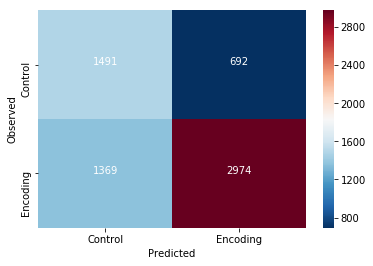

In [64]:
trial_svc.fit(X_train, y_train) #train the model

# MAKE SURE: mettre poids egal par categorie.
# class-weight: balanced!!! 

# predict the training data based on the model
y_pred = trial_svc.predict(X_train)

# calculate the model accuracy
acc = trial_svc.score(X_train, y_train)

# calculate the model precision, recall and f1 in one report
cr = classification_report(y_true=y_train,
                      y_pred = y_pred)

# get a table to help us break down these scores
cm = confusion_matrix(y_true=y_train, y_pred = y_pred)

# print results
print('accuracy:', acc)
print(cr)
print(cm)

# plot confusion matrix (training data)
cmdf = pd.DataFrame(cm, index = ['Control','Encoding'], columns = ['Control','Encoding'])
sns.heatmap(cmdf, cmap = 'RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
# label cells in matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

In [65]:
# Set up 10-fold cross-validation to evaluate the model's performance over the training set
# predict
y_pred = cross_val_predict(trial_svc, X_train, y_train,
                           groups=y_train, cv=10)
# scores
acc = cross_val_score(trial_svc, X_train, y_train,
                     groups=y_train, cv=10)

#Look at accuracy of prediction for each fold of the cross-validation
for i in range(10):
    print('Fold %s -- Acc = %s'%(i, acc[i]))

/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increa

Fold 0 -- Acc = 0.6574923547400612
Fold 1 -- Acc = 0.6422018348623854
Fold 2 -- Acc = 0.6467889908256881
Fold 3 -- Acc = 0.661042944785276
Fold 4 -- Acc = 0.6947852760736196
Fold 5 -- Acc = 0.7269938650306749
Fold 6 -- Acc = 0.6947852760736196
Fold 7 -- Acc = 0.6549079754601227
Fold 8 -- Acc = 0.7085889570552147
Fold 9 -- Acc = 0.7116564417177914


/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.6809684339564818
              precision    recall  f1-score   support

         CTL       0.52      0.68      0.59      2183
         Enc       0.81      0.68      0.74      4343

   micro avg       0.68      0.68      0.68      6526
   macro avg       0.66      0.68      0.66      6526
weighted avg       0.71      0.68      0.69      6526



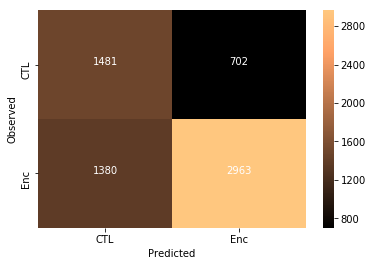

In [66]:
#look at the overall accuracy of the model

overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

thresh = overall_cm.max() / 2
cmdf = pd.DataFrame(overall_cm, index = ['CTL','Enc'], columns = ['CTL','Enc'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy = 0.6701357466063348
              precision    recall  f1-score   support

         CTL       0.51      0.64      0.57      1479
         Enc       0.79      0.68      0.73      2941

   micro avg       0.67      0.67      0.67      4420
   macro avg       0.65      0.66      0.65      4420
weighted avg       0.70      0.67      0.68      4420



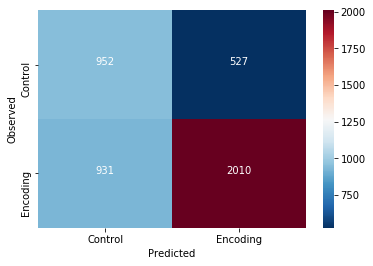

In [67]:
# Test model on unseen data from the test set

# Unscaled
trial_svc.fit(X_train, y_train)
y_pred = trial_svc.predict(X_test) # classify age class using testing data
acc = trial_svc.score(X_test, y_test) # get accuracy

cr = classification_report(y_pred=y_pred, y_true=y_test) # get prec., recall & f1
cm = confusion_matrix(y_pred=y_pred, y_true=y_test) # get confusion matrix

# print results
print('accuracy =', acc)
print(cr)

# plot results
thresh = cm.max() / 2
cmdf = pd.DataFrame(cm, index = ['Control','Encoding'], columns = ['Control','Encoding'])
sns.heatmap(cmdf, cmap='RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

In [68]:
#Display feature weights

coef_ = trial_svc.coef_[0]
print(coef_.shape)

# To interpret MIST parcellation labels:
# https://simexp.github.io/multiscale_dashboard/index.html
basc_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcellations'
basc = image.load_img(os.path.join(basc_dir, 'MIST_'+str(numnet)+'.nii'))

print(basc.header.get_data_shape())
#print(basc.header)

b_labels = os.path.join('/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcel_Information/MIST_'+str(numnet)+'.csv')
basc_labels = pd.read_csv(b_labels, sep=';')

basc_labels.insert(loc=3, column='coef', value=coef_, allow_duplicates=True)

print(basc_labels.iloc[:, 2:4])


(20,)
(53, 64, 52)
                                                 name      coef
0                          BASAL_GANGLIA_and_THALAMUS  0.098490
1                         SOMATOMOTOR_NETWORK_ventral  0.143378
2          ORBITOFRONTAL_CORTEX_and_NUCLEUS_ACCUMBENS  0.033434
3                              ASSOCIATIVE_CEREBELLUM  0.009994
4   PERIGENUAL_ANTERIOR_CINGULATE_CORTEX_and_VENTR...  0.054778
5           INFERIOR_TEMPORAL_GYRUS_and_TEMPORAL_POLE  0.009322
6                FRONTO_PARIETAL_TASK_CONTROL_NETWORK  0.038771
7               AUDITORY_NETWORK_and_POSTERIOR_INSULA -0.022850
8                               MEDIAL_VISUAL_NETWORK -0.201494
9    AMYGDALA_and_HIPPOCAMPUS_and_Peri_Insular_Sulcus  0.010123
10                         SOMATOMOTOR_NETWORK_dorsal -0.063415
11                   VENTRAL_ATTENTION_NETWORK_medial  0.074850
12                       DEFAULT_MODE_NETWORK_lateral  0.009161
13                 DEFAULT_MODE_NETWORK_posteromedial -0.024850
14                   